# Import Libraries

In [7]:
!pip install -U tensorflow_decision_forests


  Using cached tensorflow_decision_forests-1.8.1.tar.gz (15.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of tensorflow-decision-forests to determine which version is compatible with other requirements. This could take a while.


DEPRECATION: Loading egg at c:\users\sa\appdata\local\programs\python\python312\lib\site-packages\yapf-0.40.2-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
ERROR: Could not find a version that satisfies the requirement tensorflow~=2.15.0 (from tensorflow-decision-forests) (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow~=2.15.0


In [22]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Preprocessing


In [23]:
# Load and Concatenate CSV Files
def load_csv_files(folder_path):
    """
    Load all CSV files from the specified folder and concatenate them into a single DataFrame.
    Each file's name (without extension) is used as the label.
    """
    dataframes = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            label = file_name.split(".")[0]  # Use the file name (without extension) as the label
            df = pd.read_csv(os.path.join(folder_path, file_name))
            df['label'] = label  # Add a label column
            dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

# Data Loading
data_folder = r"data"
df = load_csv_files(data_folder)

# Select relevant columns for features and labels
selected_columns = ["Flex1", "Flex2", "Flex3", "Flex4", "Flex5", 
                    "AccelX", "AccelY", "AccelZ", "GyroX", "GyroY", "GyroZ", "label"]

# Ensure selected columns exist
df = df[selected_columns]

# Handle missing values by dropping rows with NaN values
df = df.dropna()

# Display label counts and explore the 'hellow' label
label_counts = df["label"].value_counts()
print("Label Counts:\n", label_counts)

label_hellow_count = df[df['label'] == 'hellow'].shape[0]
print(f"Number of instances of label 'hellow': {label_hellow_count}")

Label Counts:
 label
Yes           1286
No             973
I_Love_You     896
Hello          895
f              800
c              797
e              700
Now            699
Awkward        694
Sorry          673
Bathroom       672
d              667
Deaf           665
Goodbye        664
a              662
b              653
Name: count, dtype: int64
Number of instances of label 'hellow': 0


# Data Splitting: Features and Labels

In [24]:

# Select relevant columns for features and labels
selected_columns = ["Flex1", "Flex2", "Flex3", "Flex4", "Flex5", 
                    "AccelX", "AccelY", "AccelZ", "GyroX", "GyroY", "GyroZ", "label"]

# Ensure selected columns exist
df = df[selected_columns]

# Handle missing values by dropping rows with NaN values
df = df.dropna()

# Display label counts and explore the 'hellow' label
label_counts = df["label"].value_counts()
print("Label Counts:\n", label_counts)

label_hellow_count = df[df['label'] == 'hellow'].shape[0]
print(f"Number of instances of label 'hellow': {label_hellow_count}")

# Data Splitting: Features and Labels
X = df[["Flex1", "Flex2", "Flex3", "Flex4", "Flex5", "AccelX", "AccelY", "AccelZ", "GyroX", "GyroY", "GyroZ"]]
y = df["label"]

# Encode labels (y)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Normalize data (important for neural networks)
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

Label Counts:
 label
Yes           1286
No             973
I_Love_You     896
Hello          895
f              800
c              797
e              700
Now            699
Awkward        694
Sorry          673
Bathroom       672
d              667
Deaf           665
Goodbye        664
a              662
b              653
Name: count, dtype: int64
Number of instances of label 'hellow': 0


In [31]:
# Create the mapping between labels and their numeric encoded values
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Print the label to number mapping
print("Label to Number Mapping:")
for label, number in label_mapping.items():
    print(f"{label}: {number}")


Label to Number Mapping:
Awkward: 0
Bathroom: 1
Deaf: 2
Goodbye: 3
Hello: 4
I_Love_You: 5
No: 6
Now: 7
Sorry: 8
Yes: 9
a: 10
b: 11
c: 12
d: 13
e: 14
f: 15


# Build a simple neural network model in TensorFlow

In [26]:
# Build a deeper model with dropout and L2 regularization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Adding dropout to reduce overfitting
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # For multi-class classification
])

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' for integer labels
              metrics=['accuracy'])

# Implement Early Stopping and ReduceLROnPlateau
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])


Epoch 1/50


c:\Users\sa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1678 - loss: 2.5867 - val_accuracy: 0.4480 - val_loss: 1.7218 - learning_rate: 0.0010
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4719 - loss: 1.6822 - val_accuracy: 0.6798 - val_loss: 1.1595 - learning_rate: 0.0010
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5850 - loss: 1.2947 - val_accuracy: 0.6835 - val_loss: 1.0179 - learning_rate: 0.0010
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6522 - loss: 1.0775 - val_accuracy: 0.7270 - val_loss: 0.9024 - learning_rate: 0.0010
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6874 - loss: 0.9525 - val_accuracy: 0.7774 - val_loss: 0.7472 - learning_rate: 0.0010
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7252 - loss: 0.8693 - val_accuracy: 0.8000 - val_loss: 0.6975 - learning_rate: 0.0010
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7479 - loss: 0.7817 - val_accurac

In [27]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Model Evaluation: Accuracy and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Model Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Model Accuracy: {accuracy}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9007 - loss: 0.3022
Test Accuracy: 0.9068548679351807
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Accuracy: 0.9068548387096774


# Model Evaluation: Accuracy and Classification Report


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.78      0.88       139
           1       0.92      0.91      0.92       134
           2       0.96      0.99      0.98       133
           3       1.00      0.94      0.97       133
           4       0.74      0.94      0.83       179
           5       0.95      0.84      0.89       179
           6       0.76      0.84      0.80       195
           7       1.00      0.89      0.94       140
           8       0.99      0.94      0.97       135
           9       0.80      0.86      0.83       257
          10       1.00      0.96      0.98       132
          11       1.00      0.99      1.00       131
          12       0.88      0.84      0.86       160
          13       0.99      0.96      0.98       133
          14       0.99      0.94      0.96       140
          15       0.89      0.97      0.93       160

    accuracy                           0.91      2480
 

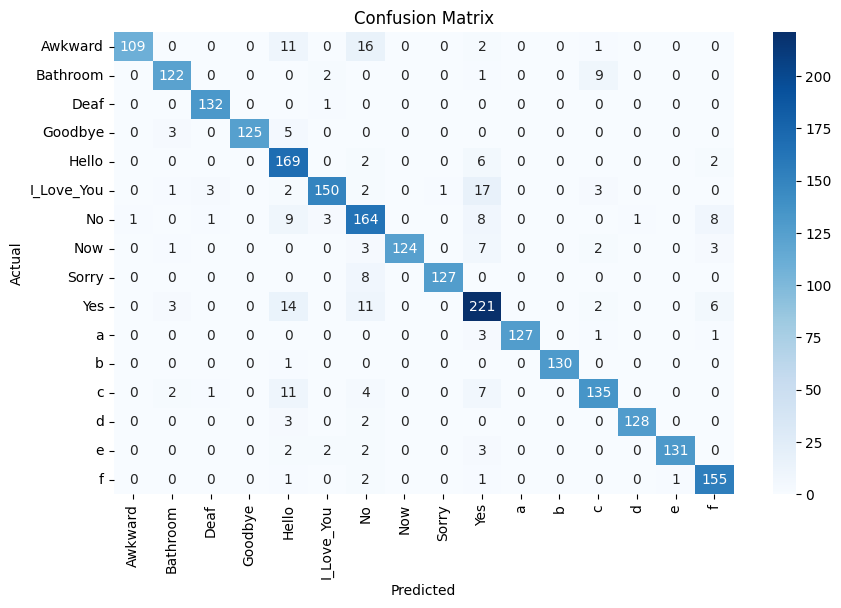

Precision: 0.9152958103782508
Recall: 0.9068548387096774
F1 Score: 0.9084704961656231


In [28]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred_classes, average="weighted")
recall = recall_score(y_test, y_pred_classes, average="weighted")
f1 = f1_score(y_test, y_pred_classes, average="weighted")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Save the Trained Model

In [29]:
# Save the Trained Model
# Save the model as a .h5 file
model.save("improved_model.h5")

# Convert the trained model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Perform the conversion
tflite_model = converter.convert()

# Save the converted model to a file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model has been saved as 'model.tflite'")

INFO:tensorflow:Assets written to: C:\Users\sa\AppData\Local\Temp\tmp5hv_zc36\assets


INFO:tensorflow:Assets written to: C:\Users\sa\AppData\Local\Temp\tmp5hv_zc36\assets


Saved artifact at 'C:\Users\sa\AppData\Local\Temp\tmp5hv_zc36'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 11), dtype=tf.float32, name='keras_tensor_36')
Output Type:
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)
Captures:
  1913632717328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1913733999184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1913733994000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1913733998416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1913733997264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1913734001296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1913734000720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1913733996880: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model has been saved as 'model.tflite'
